In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
full_demand = pd.read_csv('./Form-714-csv-files-June-2021/Part 3 Schedule 2 - Planning Area Hourly Demand.csv')

In [3]:
hour_columns = [f'hour{ii:02}' for ii in range(1, 25)]
tep_data = full_demand[['plan_date'] + hour_columns].loc[full_demand['respondent_id'] == 266]
tep_dates = full_demand['plan_date'].loc[full_demand['respondent_id'] == 266]
tep_data.rename(columns={f'hour{ii:02}': ii for ii in range(1, 25)}, inplace=True)
tep_data = tep_data.melt(id_vars=['plan_date'], var_name='hour', value_name='demand')
tep_data.index = pd.to_datetime(tep_data['plan_date']) + pd.to_timedelta(tep_data['hour'].astype(int) - 1, unit='h')
tep_data.drop(columns=['plan_date', 'hour'], inplace=True)
tep_data.sort_index(inplace=True)

<Axes: title={'center': 'TEP demand'}>

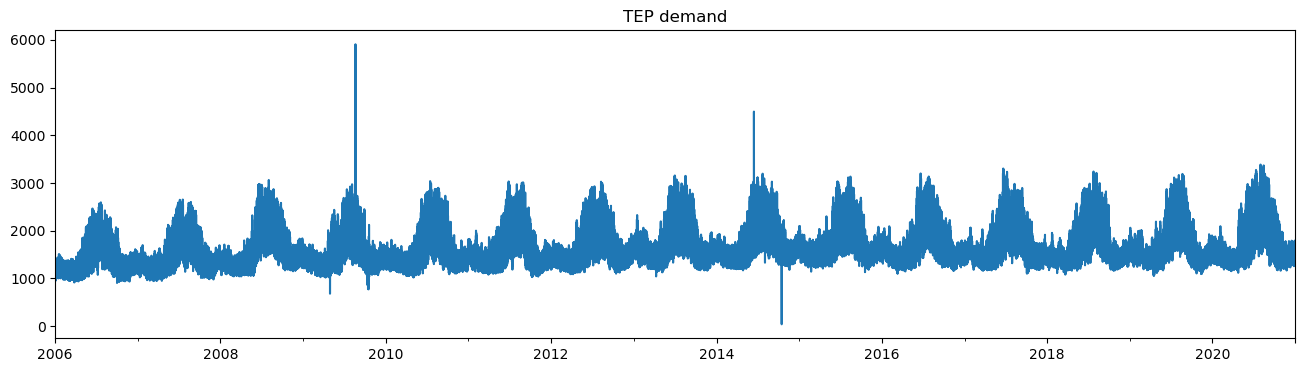

In [4]:
figsize = plt.figaspect(1/4)
tep_data.plot(figsize=figsize, title='TEP demand', legend=False)

<Axes: title={'center': 'TEP demand 7 day average'}>

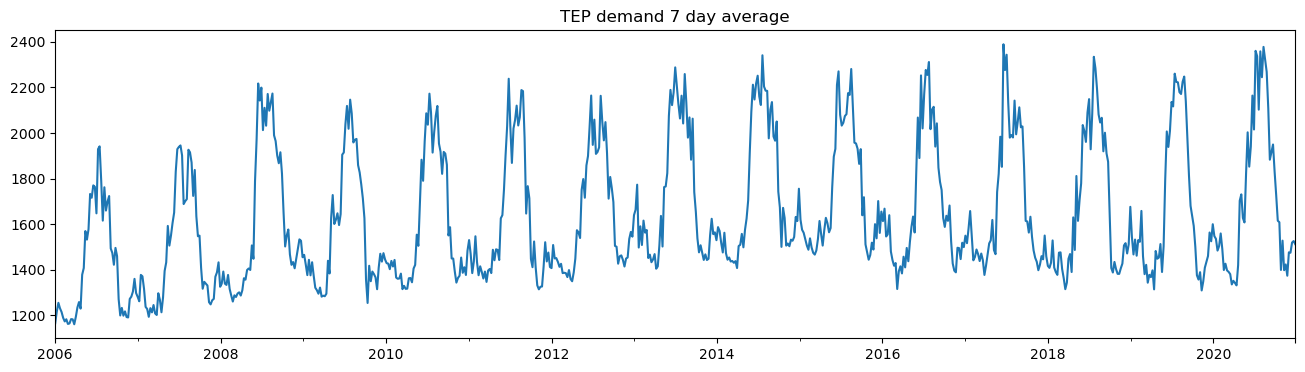

In [5]:
figsize = plt.figaspect(1/4)
tep_data.resample('7d').mean().plot(figsize=figsize, title='TEP demand 7 day average', legend=False)

In [6]:
def quantile_doy(df, quantile=0.5, window=1):
    # to_return = df.groupby(df.index.dayofyear//window)['demand'].quantile(quantile) 
    to_return = df.groupby(df.index.date)['demand'].sum()
    to_return.index = pd.to_datetime(to_return.index)
    to_return = to_return.groupby(to_return.index.dayofyear//window).quantile(quantile) 
    to_return.index = to_return.index * window
    return to_return

In [7]:
doys = pd.date_range('2001-01-01', '2001-12-31', freq='MS').day_of_year.values
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

Text(0, 0.5, 'Demand')

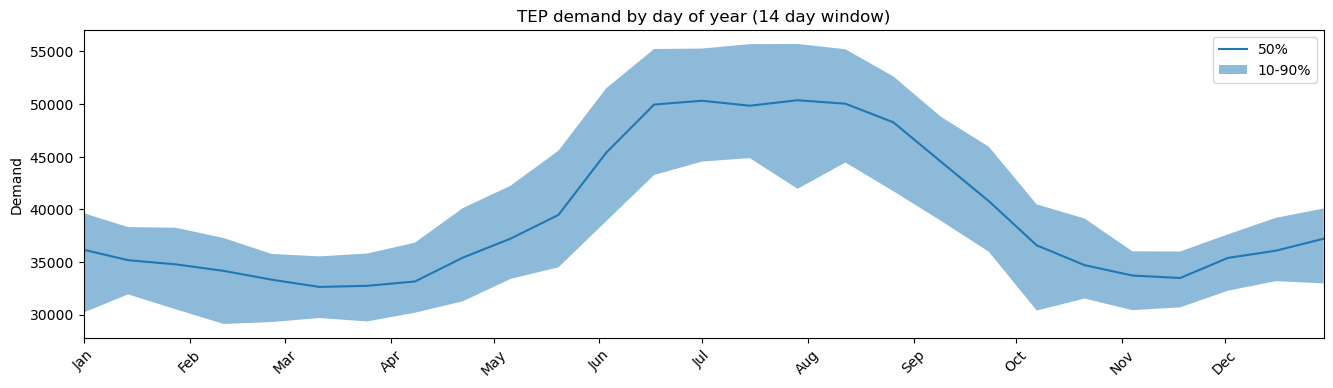

In [8]:
figsize= plt.figaspect(1/4)
plt.figure(figsize=figsize)
plt.plot(quantile_doy(tep_data, quantile=0.5, window=14), label='50%')
plt.fill_between(quantile_doy(tep_data, quantile=0.1, window=14).index, quantile_doy(tep_data, quantile=0.1, window=14), quantile_doy(tep_data, quantile=0.9, window=14), alpha=0.5, label='10-90%')
plt.xticks(doys, months, rotation=45)
plt.legend()
plt.xlim(1, 364)
plt.title('TEP demand by day of year (14 day window)')
plt.ylabel('Demand')

In [9]:
def month_quantile(df, month, quantile):
    to_return = df.loc[df.index.month == month]
    to_return = to_return.groupby(to_return.index.hour)['demand'].quantile(quantile)
    return to_return

In [10]:

hourly_quantiles = pd.DataFrame(
    index=pd.MultiIndex.from_product([range(1, 13), range(24)], names=['month', 'hour']),
    columns=[ii for ii in range(0, 101, 10)]
)
for a_month in range(1, 13):
    for a_quantile in hourly_quantiles.columns:
        hourly_quantiles.loc[(a_month, ), a_quantile] = month_quantile(tep_data, a_month, float(a_quantile)/100).values

In [11]:
hourly_quantiles = hourly_quantiles.astype(float)

Text(0.5, 1.0, 'Hourly demand')

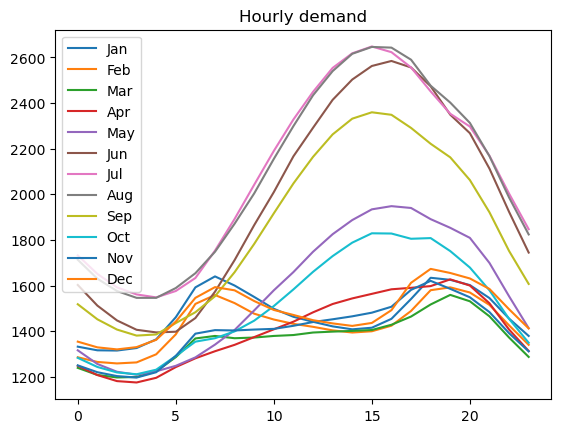

In [12]:
plt.figure()
for a_month in range(1, 13):
    plt.plot(hourly_quantiles[50].loc[(a_month, )], label=months[a_month-1])
    plt.legend()
plt.title('Hourly demand')

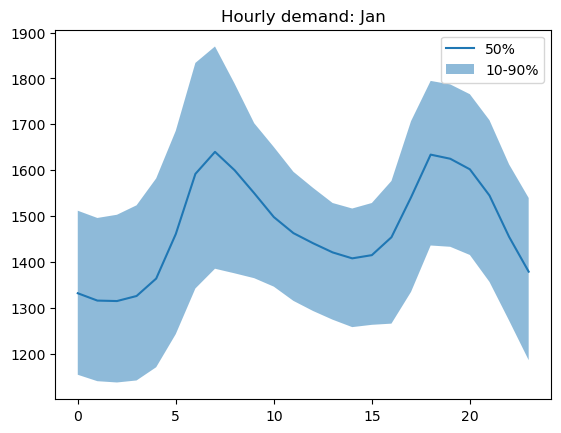

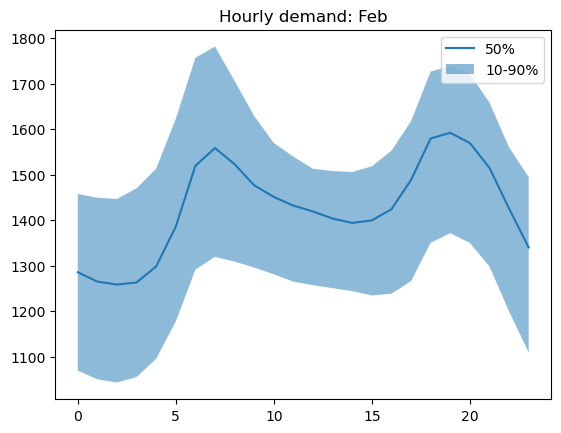

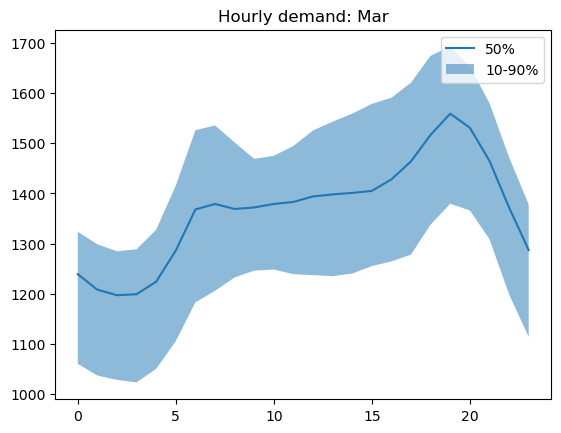

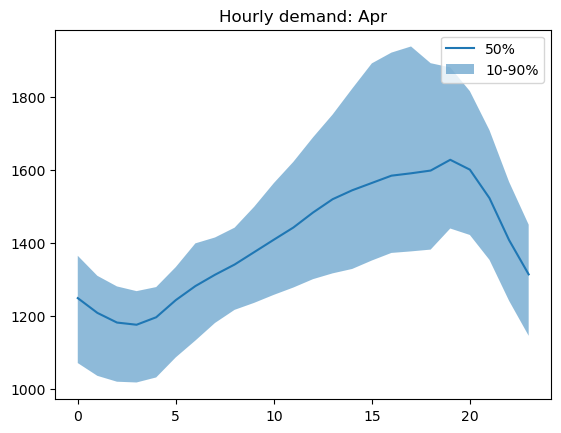

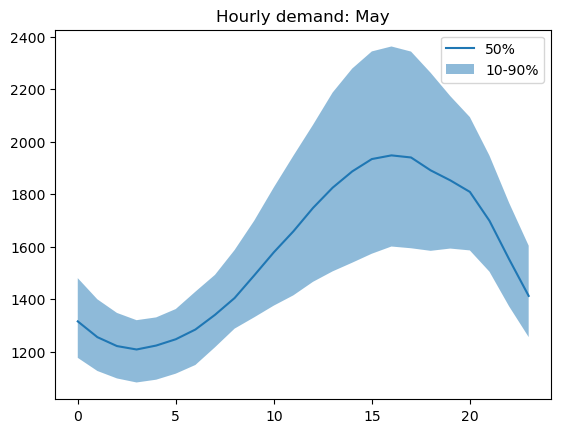

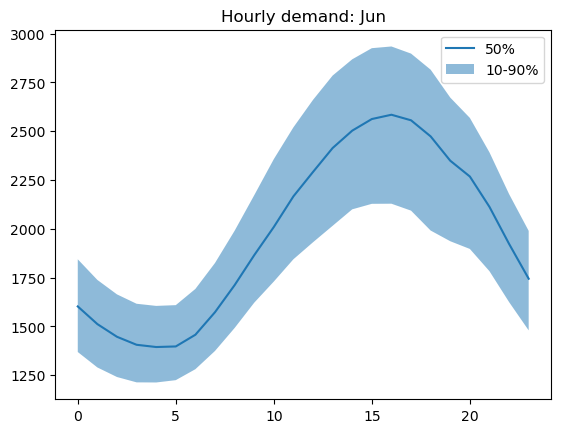

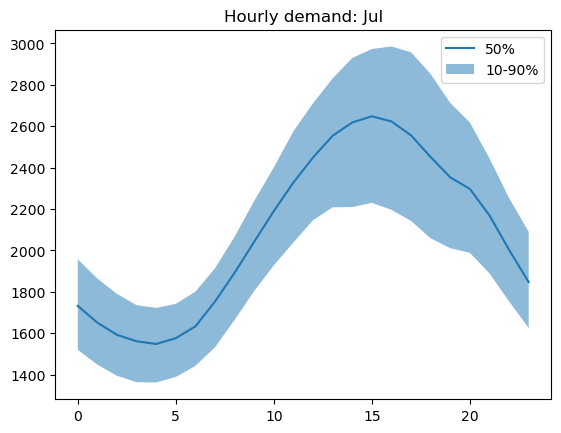

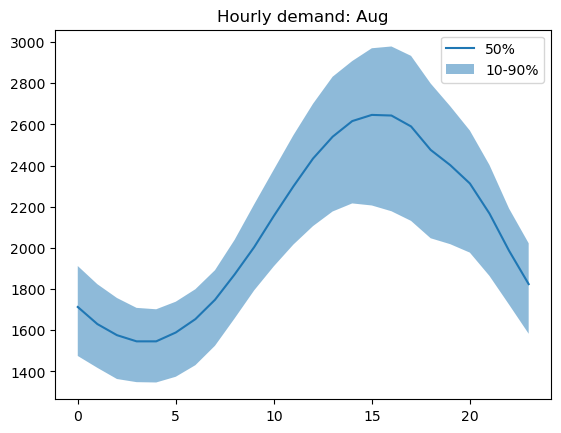

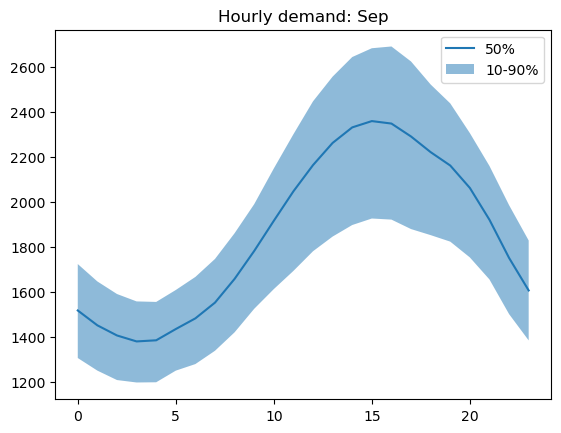

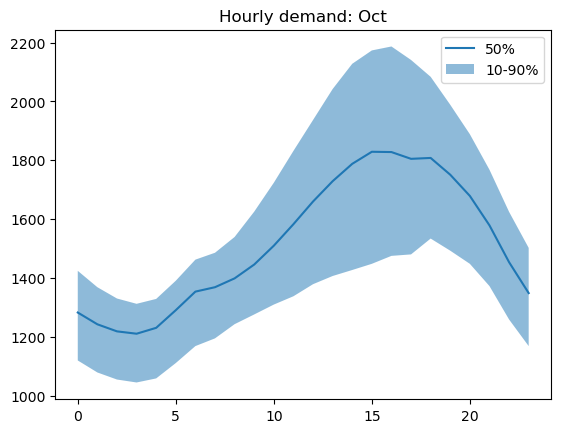

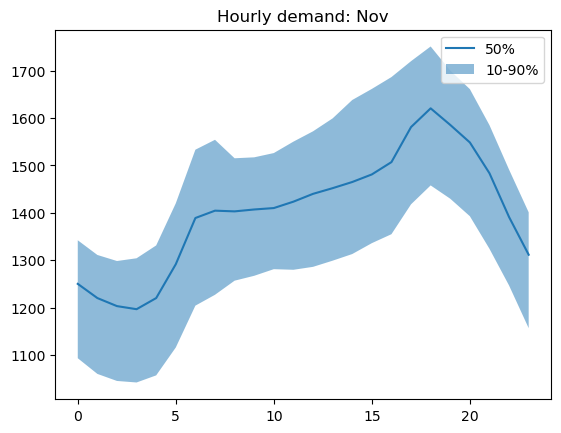

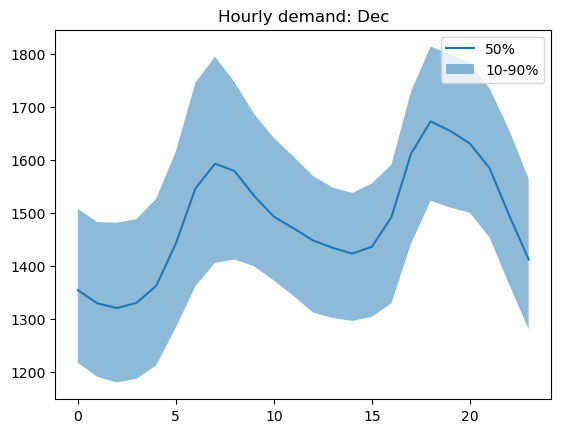

In [13]:
for a_month in range(1, 13):
    plt.figure()
    plt.plot(hourly_quantiles[50].loc[(a_month, )], label='50%')
    plt.fill_between(
        hourly_quantiles.index.levels[1], hourly_quantiles[10].loc[(a_month, )], hourly_quantiles[90].loc[(a_month, )], alpha=0.5, label='10-90%')
    plt.legend()
    plt.title(f'Hourly demand: {months[a_month-1]}')